In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import dill
import sympy
from tqdm import tqdm
from triangle import triangulate
from random import choice, sample
from utils import get_middle_indices

### Load precomputed integrals

In [2]:
lagrange_cubic_poisson_matrix = dill.load(
    open("../calculations/lagrange_cubic_poisson_matrix", "rb")
)
lagrange_cubic_poisson_right_values = dill.load(
    open("../calculations/lagrange_cubic_poisson_right_values", "rb")
)

### Initialize the domain

In [3]:
t = np.linspace(0, 2 * np.pi, 30, endpoint=False)
points = np.stack((np.cos(t), np.sin(t))).T
seg = np.array(
    [[j, j + 1] for j in range(points.shape[0] - 1)] + [[points.shape[0] - 1, 0]]
)

### Run triangulation

In [4]:
cndt = triangulate({"vertices": points, "segments": seg}, opts="pq30a0.05neo1s")
points = cndt["vertices"]
triangles = cndt["triangles"]
neighbours = cndt["neighbors"]
vertex_marker_is_boundary = cndt["vertex_markers"]
edges = cndt["edges"]
edge_marker_is_boundary = cndt["edge_markers"]
print(f"Total number of points {points.shape[0]}")

Total number of points 73


## Make $P_{3}$ from $P_{1}$

In [5]:
new_triangles = np.zeros((triangles.shape[0], 10), dtype=int)

### Make map from triangles to edges

In [6]:
triangle_to_edge = np.zeros_like(triangles)

In [7]:
def get_local_edges(points, triangle, sorted_edges):
    result = []

    for pair in triangle[np.array([[1, 2], [0, 2], [0, 1]])]:
        pairs_sorted_idx = np.argsort(pair)
        idx = np.where(np.all(pair[pairs_sorted_idx] == sorted_edges, axis=-1))[0][0]
        result.append(idx)

    return result

In [8]:
edges_sorted_idx = np.argsort(edges, axis=-1)
sorted_edges = np.take_along_axis(edges, edges_sorted_idx, axis=-1)

In [9]:
for tidx, triangle in enumerate(triangles):
    result = get_local_edges(points, triangle, sorted_edges)
    triangle_to_edge[tidx] = result

### Add trisection points

In [10]:
num_nodes = points.shape[0]

In [11]:
trisection_points = []

for eidx, edge in enumerate(edges):
    m1 = points[edge[0]] + (-points[edge[0]] + points[edge[1]]) * 1 / 3
    m2 = points[edge[0]] + (-points[edge[0]] + points[edge[1]]) * 2 / 3

    points = np.concatenate([points, [m1, m2]])
    trisection_points.append(np.array([num_nodes + 2 * eidx, num_nodes + 2 * eidx + 1]))

    if edge_marker_is_boundary[eidx] == 1:
        vertex_marker_is_boundary = np.concatenate(
            [vertex_marker_is_boundary, [[1], [1]]]
        )
    else:
        vertex_marker_is_boundary = np.concatenate(
            [vertex_marker_is_boundary, [[0], [0]]]
        )


trisection_points = np.stack(trisection_points)

In [12]:
for tidx, triangle in enumerate(triangles):
    new_triangles[tidx][:3] = triangle

    res = []

    for global_edge, local_edge in zip(
        triangle_to_edge[tidx], triangle[np.array([[1, 2], [0, 2], [0, 1]])]
    ):
        what = trisection_points[global_edge]
        if not np.all(edges[global_edge] == local_edge):
            what = what[::-1]

        res.extend(what.tolist())

    new_triangles[tidx][3:-1] = res

### Add triangles' middle points

In [13]:
num_nodes = points.shape[0]

In [14]:
for tidx, triangle in enumerate(new_triangles):
    mid_point = points[triangle[:3]].mean(axis=0)
    points = np.concatenate([points, [mid_point]])
    triangle[-1] = num_nodes + tidx
    vertex_marker_is_boundary = np.concatenate([vertex_marker_is_boundary, [[0]]])

### Visualize the triangulation

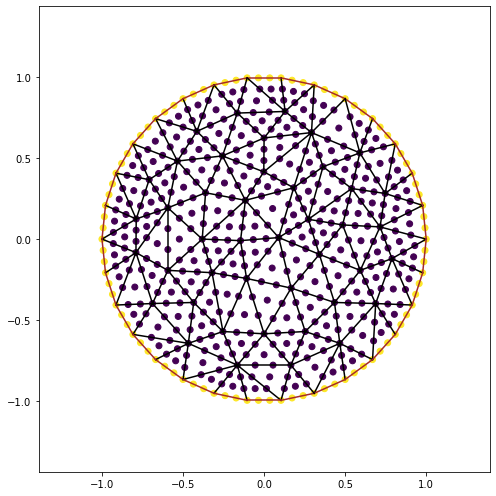

In [15]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(7, 7))
ax.axis("equal")

cl = ["black", "brown"]

for eidx, edge in enumerate(edges):
    ax.plot(
        points[edge][:, 0],
        points[edge][:, 1],
        color=cl[edge_marker_is_boundary[eidx][0]],
    )
    position = points[edge].mean(axis=0)

ax.scatter(*points.T, c=vertex_marker_is_boundary)

ax.set_xlim([points[:, 0].min() - 1 / 2, points[:, 0].max() + 1 / 2])
ax.set_ylim([points[:, 1].min() - 1 / 2, points[:, 1].max() + 1 / 2])

fig.tight_layout()
plt.tight_layout()

plt.show()

In [16]:
x, y = sympy.symbols("x y")

In [17]:
F = sympy.Float(1)
right_vals = np.zeros((points.shape[0]))
right_vals[:] = sympy.lambdify((x, y), F)(*points.T)

In [18]:
matrix = np.zeros((points.shape[0], points.shape[0]))
b = np.zeros(points.shape[0])

for idx, element in enumerate(tqdm(new_triangles)):
    x1, x2, x3 = points[element[0], 0], points[element[1], 0], points[element[2], 0]
    y1, y2, y3 = points[element[0], 1], points[element[1], 1], points[element[2], 1]

    delta = x1 * y2 - x1 * y3 - x2 * y1 + x2 * y3 + x3 * y1 - x3 * y2

    P_1_x = (-y1 + y3) / delta
    P_1_y = (+x1 - x3) / delta

    P_2_x = (+y1 - y2) / delta
    P_2_y = (-x1 + x2) / delta

    arg = [P_1_x, P_2_x, P_1_y, P_2_y, *right_vals[element]]

    FF = lagrange_cubic_poisson_matrix(*arg)
    ff = lagrange_cubic_poisson_right_values(*arg)

    for local_point in range(10):
        if vertex_marker_is_boundary[element[local_point]] == True:
            matrix[element[local_point], element[local_point]] = 1
            b[element[local_point]] *= 0
        else:
            for i in range(10):
                matrix[element[local_point], element[i]] += 2 * FF[local_point, i]

            b[element[local_point]] -= 2 * ff[local_point]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 2570.87it/s]


In [19]:
F = np.linalg.solve(matrix, b)

In [20]:
_x_ = points[:, 0]
_y_ = points[:, 1]

In [21]:
U = -(1 - x**2 - y**2) / 4
U = sympy.lambdify((x, y), U)(*points.T)

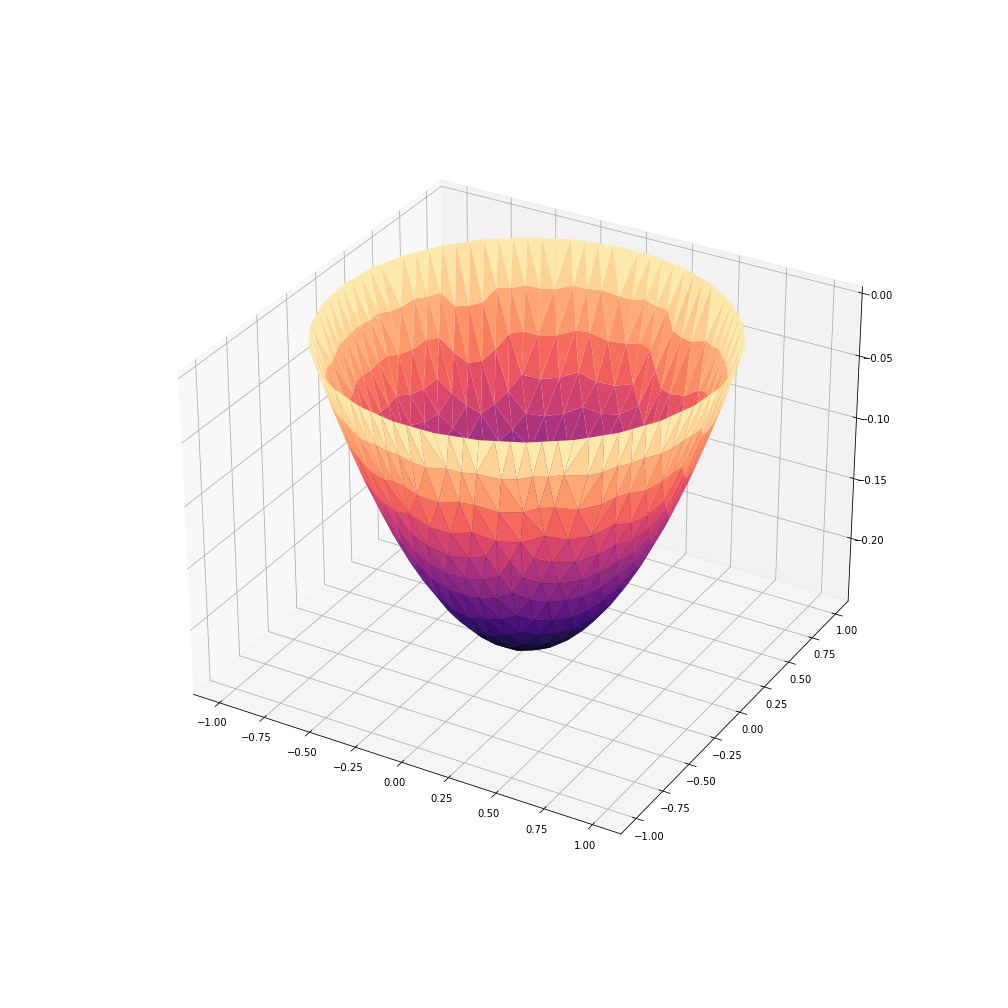

In [22]:
%matplotlib widget
fig = plt.figure(figsize=(14, 14))
ax = plt.axes(projection="3d")
ax.plot_trisurf(points[:, 0], points[:, 1], F, cmap="magma", triangles=new_triangles)
plt.show()

### $ \lVert F - \hat{F} \rVert_{\infty}$

In [23]:
abs(U - F).max()

0.002428044362911685